In [86]:
# Using -q for a quieter installation in the notebook
!pip install datasets tiktoken tqdm numpy matplotlib pandas -q

# --- Core Torch and Helpers ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import os
import time
from contextlib import nullcontext
from dataclasses import dataclass
from torch import tensor

# --- Data Handling ---
import numpy as np
from datasets import load_dataset
import tiktoken
from tqdm.auto import tqdm

# --- Plotting and Analysis ---
import matplotlib.pyplot as plt
import pandas as pd

print("All dependencies installed and imported successfully.")
# Verify GPU is available
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("No GPU detected. Running on CPU.")


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
All dependencies installed and imported successfully.
GPU detected: NVIDIA GeForce RTX 5090
PyTorch version: 2.8.0.dev20250319+cu128
CUDA version: 12.8


In [87]:
# --- Global Training Config ---
BATCH_SIZE = 32          # Number of sequences in a batch
BLOCK_SIZE = 256         # Context length of the model
MAX_ITERS = 5000         # Total training iterations
EVAL_INTERVAL = 250      # How often to evaluate and print loss
EVAL_ITERS = 100         # Number of batches to average for validation loss
LEARNING_RATE = 3e-4     # Max learning rate for the optimizer
WARMUP_ITERS = 200       # Number of iterations for learning rate warmup
MIN_LR = 3e-5            # Minimum learning rate after cosine decay

In [88]:
# --- Device and Precision Config ---
# Automatically selects 'cuda' if available, otherwise 'cpu'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Use bfloat16 for training if available (on A100+ GPUs), otherwise float16.
# This maximizes performance and prevents common float16 overflow issues.
DTYPE = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
PTDTYPE = {'float16': torch.float16, 'bfloat16': torch.bfloat16, 'float32': torch.float32}[DTYPE]
# Create the autocast context manager for mixed-precision training
CTX = nullcontext() if DEVICE == 'cpu' else torch.amp.autocast(device_type=DEVICE, dtype=PTDTYPE)
# GradScaler is only needed for float16, not bfloat16 or float32
SCALER = torch.cuda.amp.GradScaler(enabled=(DTYPE == 'float16'))

/tmp/ipykernel_102/3088237724.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  SCALER = torch.cuda.amp.GradScaler(enabled=(DTYPE == 'float16'))


In [ ]:
# --- Base Model Architecture Config ---
# We will use these settings for all four models to ensure a fair comparison.
@dataclass
class BaseModelConfig:
    n_layer: int = 6
    n_head: int = 8
    n_embd: int = 256
    vocab_size: int = 50257  # Standard for GPT-2 tokenizer
    block_size: int = BLOCK_SIZE
    dropout: float = 0.1
    bias: bool = False # Set to False for LayerNorms and Linears, as is common practice
    
    MLA_COMPRESSION_RATIO = 0.5
    d_latent: int = int(256 * MLA_COMPRESSION_RATIO) # d_model * ratio
    d_rope: int = 16 

In [90]:
# Create an instance of the config
BASE_CONFIG = BaseModelConfig()

In [91]:
GQA_N_GROUPS = 2
assert BASE_CONFIG.n_head % GQA_N_GROUPS == 0, "n_head must be divisible by n_groups for GQA"

In [92]:
print(f"Running on device: {DEVICE}")
print(f"Using data type: {DTYPE}")
print(f"Base model config: {BASE_CONFIG.n_layer} layers, {BASE_CONFIG.n_head} heads, {BASE_CONFIG.n_embd} embedding dim.")

Running on device: cuda
Using data type: bfloat16
Base model config: 6 layers, 8 heads, 256 embedding dim.


In [93]:
# --- Dataset Configuration ---
DATASET_NAME = "roneneldan/TinyStories"
TRAIN_BIN_FILE = "train.bin"
VAL_BIN_FILE = "val.bin"
TOKENIZER_MODEL = "gpt2"

In [94]:
# --- Tokenization and File Writing ---
if not (os.path.exists(TRAIN_BIN_FILE) and os.path.exists(VAL_BIN_FILE)):
    print("Binary data files not found. Starting data download and tokenization...")

    # Load the dataset from Hugging Face
    ds = load_dataset(DATASET_NAME)

    # Initialize the tokenizer
    enc = tiktoken.get_encoding(TOKENIZER_MODEL)
    assert enc.max_token_value < 2**16, "Tokenizer vocab size is too large for uint16"

    def process_and_tokenize(example):
        """Tokenize a single text example and return token IDs and length."""
        ids = enc.encode_ordinary(example['text'])
        return {'ids': ids, 'len': len(ids)}

    # Tokenize the dataset in parallel
    tokenized_ds = ds.map(
        process_and_tokenize,
        remove_columns=['text'],
        desc="Tokenizing splits",
        num_proc=os.cpu_count(),
    )

    # Write tokenized data to memory-mapped binary files
    for split, dset in tokenized_ds.items():
        # Use a consistent naming convention (validation -> val)
        split_name = 'val' if split == 'validation' else split
        filename = f"{split_name}.bin"

        total_tokens = np.sum(dset['len'], dtype=np.uint64)
        print(f"Found {total_tokens:,} tokens in the '{split}' split.")

        # Use uint16 for memory efficiency, as vocab size allows it
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(total_tokens,))

        print(f"Writing tokens to {filename}...")
        current_idx = 0
        # Process in batches to manage memory during concatenation
        for batch in tqdm(dset.iter(batch_size=2048), total=len(dset)//2048):
            concatenated_ids = np.concatenate(batch['ids'])
            arr[current_idx : current_idx + len(concatenated_ids)] = concatenated_ids
            current_idx += len(concatenated_ids)

        arr.flush()
    print("Tokenization and file writing complete.")
else:
    print("Found existing train.bin and val.bin files. Skipping data preparation.")

Found existing train.bin and val.bin files. Skipping data preparation.


In [ ]:
# --- Data Loading Function for Training ---
def get_batch(split):
    """
    Loads a batch of data from the appropriate binary file.
    This function is designed to be called repeatedly during training.
    """
    filename = TRAIN_BIN_FILE if split == 'train' else VAL_BIN_FILE
    # Re-map the file in each call to avoid potential memory issues with long-running processes
    data = np.memmap(filename, dtype=np.uint16, mode='r')

    # Generate random starting indices for each sequence in the batch
    ix = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE,))

    # Create input (x) and target (y) sequences
    x = torch.stack([torch.from_numpy((data[i:i+BLOCK_SIZE]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+BLOCK_SIZE]).astype(np.int64)) for i in ix])

    # Move data to the configured device
    return x.to(DEVICE), y.to(DEVICE)

print("\nData loading utilities are ready.")


Data loading utilities are ready.


In [96]:
class LayerNorm(nn.Module):
    """ A custom LayerNorm implementation. """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [97]:
class MLP(nn.Module):
    """ The standard Feed-Forward Network (FFN) block. """
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [98]:
@torch.no_grad()
def estimate_loss(model, ctx):
    """
    Evaluates the model's loss on the train and validation sets.
    """
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            with ctx:
                # The forward pass now only returns what we need
                _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

print("Shared `estimate_loss` function is defined.")

Shared `estimate_loss` function is defined.


In [99]:
class MultiHeadAttention(nn.Module):
    """
    A standard Multi-Head Attention module with an explicit KV Cache for efficient inference.
    This implementation uses a single linear layer to project Q, K, and V simultaneously
    for efficiency, and leverages PyTorch's built-in scaled_dot_product_attention.
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # A single linear layer to project inputs to Q, K, V simultaneously
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection layer
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, x, kv_cache=None):
        B, T, C = x.size() # Batch size, sequence length, embedding dimensionality
        head_size = C // self.n_head

        # 1. Project to Q, K, V for all heads in batch and split
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)

        # 2. Reshape Q, K, V to prepare for multi-head attention
        # (B, T, C) -> (B, T, n_head, head_size) -> (B, n_head, T, head_size)
        q = q.view(B, T, self.n_head, head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, head_size).transpose(1, 2)

        # --- KV Cache Logic ---
        if kv_cache is not None:
            # This is an inference step (T=1). Concatenate with the cached keys and values.
            cached_k, cached_v = kv_cache
            # Concatenate along the sequence length dimension (dim=2)
            k = torch.cat([cached_k, k], dim=2)
            v = torch.cat([cached_v, v], dim=2)
        
        # The current keys and values become the new cache for the next step.
        current_kv_cache = (k, v)

        # 3. Perform attention using PyTorch's efficient implementation.
        # is_causal=True handles masking for training/prefill where T > 1.
        # During inference with a KV cache, T=1, so is_causal=False is correct as we attend to all past tokens.
        y = torch.nn.functional.scaled_dot_product_attention(
            q, k, v, attn_mask=None,
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=(kv_cache is None) # Causal mask only for training/prefill (T > 1)
        )

        # 4. Concatenate heads and project back to the embedding dimension
        # (B, n_head, T, head_size) -> (B, T, n_head, head_size) -> (B, T, C)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        
        return y, current_kv_cache

print("Attention Mechanism 1: Multi-Head Attention (MHA) with KV Cache defined.")

Attention Mechanism 1: Multi-Head Attention (MHA) with KV Cache defined.


In [100]:
class MultiQueryAttention(nn.Module):
    """
    Multi-Query Attention (MQA) module with an explicit KV Cache.
    In MQA, all Query heads share a single Key and Value head. This significantly reduces
    the size of the KV cache and the number of parameters, speeding up inference.
    This implementation relies on the broadcasting feature of scaled_dot_product_attention.
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_size = config.n_embd // config.n_head
        self.dropout = config.dropout

        # Linear projections for Q (multi-headed), K (single), and V (single)
        self.q_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.k_attn = nn.Linear(config.n_embd, self.head_size, bias=config.bias)
        self.v_attn = nn.Linear(config.n_embd, self.head_size, bias=config.bias)

        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.resid_dropout = nn.Dropout(config.dropout)
        

    def forward(self, x, kv_cache=None):
        B, T, C = x.size() # Batch size, sequence length, embedding dimensionality

        # 1. Project Q, K, V
        # Q is multi-headed: (B, T, C) -> (B, T, n_head, head_size) -> (B, n_head, T, head_size)
        q = self.q_attn(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        # K and V are single-headed: (B, T, C) -> (B, T, head_size) -> (B, 1, T, head_size)
        k = self.k_attn(x).view(B, T, 1, self.head_size).transpose(1, 2)
        v = self.v_attn(x).view(B, T, 1, self.head_size).transpose(1, 2)

        # --- KV Cache Logic ---
        if kv_cache is not None:
            cached_k, cached_v = kv_cache
            k = torch.cat([cached_k, k], dim=2)
            v = torch.cat([cached_v, v], dim=2)
        current_kv_cache = (k, v)

        # 3. Perform attention. The single K/V head (B, 1, T, hs) will be
        # broadcasted automatically to match the Q heads (B, n_head, T, hs).
        y = torch.nn.functional.scaled_dot_product_attention(
            q, k, v, attn_mask=None,
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=(kv_cache is None)
        )

        # 4. Reshape and project
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        return y, current_kv_cache

print("Attention Mechanism 2: Multi-Query Attention (MQA) with KV Cache defined.")

Attention Mechanism 2: Multi-Query Attention (MQA) with KV Cache defined.


In [ ]:
class GroupedQueryAttention(nn.Module):
    """
    Grouped-Query Attention (GQA) module with an explicit KV Cache.
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_size = config.n_embd // config.n_head
        self.dropout = config.dropout

        self.n_kv_groups = GQA_N_GROUPS
        assert config.n_head % self.n_kv_groups == 0
        self.n_kv_heads = config.n_head // self.n_kv_groups

        self.q_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.kv_attn = nn.Linear(config.n_embd, 2 * self.n_kv_heads * self.head_size, bias=config.bias)

        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.resid_dropout = nn.Dropout(config.dropout)

    def repeat_kv(self, x: torch.Tensor, n_rep: int) -> torch.Tensor:
        """
        Efficiently repeat the K and V tensors to match the number of Q heads.
        (B, n_kv_heads, T, head_size) -> (B, n_head, T, head_size)
        """
        B, n_kv_heads, T, head_size = x.shape
        if n_rep == 1:
            return x
        # Reshape to (B, n_kv_heads, 1, T, head_size) and expand to (B, n_kv_heads, n_rep, T, head_size)
        # Then reshape back to (B, n_head, T, head_size)
        return (
            x[:, :, None, :, :]
            .expand(B, n_kv_heads, n_rep, T, head_size)
            .reshape(B, n_kv_heads * n_rep, T, head_size)
        )

    def forward(self, x, kv_cache=None):
        B, T, C = x.size()

        q = self.q_attn(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k, v = self.kv_attn(x).split(self.n_kv_heads * self.head_size, dim=2)

        k = k.view(B, T, self.n_kv_heads, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.n_kv_heads, self.head_size).transpose(1, 2)

        if kv_cache is not None:
            cached_k, cached_v = kv_cache
            k = torch.cat([cached_k, k], dim=2)
            v = torch.cat([cached_v, v], dim=2)
        current_kv_cache = (k, v)

        # --- FIX APPLIED HERE ---
        # Repeat K and V to match the number of Q heads
        k = self.repeat_kv(k, self.n_kv_groups)
        v = self.repeat_kv(v, self.n_kv_groups)

        y = torch.nn.functional.scaled_dot_product_attention(
            q, k, v, attn_mask=None,
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=(kv_cache is None)
        )

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        return y, current_kv_cache

print("Attention Mechanism 3: Grouped-Query Attention (GQA) with KV Cache defined.")

Attention Mechanism 3: Grouped-Query Attention (GQA) with KV Cache defined.


In [ ]:
from torch import Tensor

# ---------- Rotary Positional Encoding (with KV Cache support) ----------
class RotaryPositionalEncoding(nn.Module):
    def __init__(self, d_rope: int, max_seq_len: int = 2048):
        super().__init__()
        assert d_rope % 2 == 0
        inv_freq = 1.0 / (10000 ** (torch.arange(0, d_rope, 2) / d_rope))
        self.register_buffer("inv_freq", inv_freq)
        
        t = torch.arange(max_seq_len).unsqueeze(1)
        freqs = t * self.inv_freq.unsqueeze(0)
        self.register_buffer("freqs_cis", torch.polar(torch.ones_like(freqs), freqs))

    def forward(self, x: Tensor, start_pos: int = 0) -> Tensor:
        B, H, T, _ = x.shape
        # Slice the pre-computed frequencies based on the current sequence length and starting position.
        rot = self.freqs_cis[start_pos : start_pos + T]
        
        x_complex = torch.view_as_complex(x.float().reshape(B, H, T, -1, 2))
        # Reshape rot for broadcasting: [T, d_rope/2] -> [1, 1, T, d_rope/2]
        x_rot = x_complex * rot.unsqueeze(0).unsqueeze(0)
        x_rot = torch.view_as_real(x_rot).reshape(B, H, T, -1)
        return x_rot.type_as(x)

# ---------- DeepSeek-V3 Multi-Head Latent Attention (MLA) ----------
class MLAAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.d_head = config.n_embd // config.n_head
        self.d_rope = config.d_rope
        self.d_latent = config.d_latent
        
        self.d_content = self.d_head - self.d_rope
        assert self.d_content >= 0, "d_rope cannot be larger than d_head"

        self.W_dq = nn.Linear(self.n_embd, self.d_latent, bias=config.bias)
        self.W_dkv = nn.Linear(self.n_embd, self.d_latent, bias=config.bias)
        self.W_uq_c = nn.Linear(self.d_latent, self.n_head * self.d_content, bias=config.bias)
        self.W_uq_r = nn.Linear(self.d_latent, self.n_head * self.d_rope, bias=config.bias)
        self.W_uk_c = nn.Linear(self.d_latent, self.n_head * self.d_content, bias=config.bias)
        self.W_uk_r = nn.Linear(self.d_latent, self.n_head * self.d_rope, bias=config.bias)
        self.W_uv = nn.Linear(self.d_latent, self.n_head * self.d_head, bias=config.bias)
        self.W_o = nn.Linear(self.n_embd, self.n_embd, bias=config.bias)
        
        # Initialize RoPE with a larger capacity to handle generation.
        self.rope = RotaryPositionalEncoding(self.d_rope, config.block_size * 2)
        self.dropout_p = config.dropout
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, x: Tensor, kv_cache=None):
        B, T, C = x.shape
        
        start_pos = 0
        if kv_cache is not None and "kv_latent" in kv_cache:
            start_pos = kv_cache["kv_latent"].shape[1]

        q_latent = self.W_dq(x)
        q_c = self.W_uq_c(q_latent).view(B, T, self.n_head, self.d_content).transpose(1, 2)
        q_r = self.W_uq_r(q_latent).view(B, T, self.n_head, self.d_rope).transpose(1, 2)
        q_r = self.rope(q_r, start_pos=start_pos)
        q = torch.cat([q_c, q_r], dim=-1) if self.d_content > 0 else q_r

        kv_latent_new = self.W_dkv(x)
        
        if kv_cache is not None and "kv_latent" in kv_cache:
            kv_latent_full = torch.cat([kv_cache["kv_latent"], kv_latent_new], dim=1)
        else:
            kv_latent_full = kv_latent_new
        
        current_cache = {"kv_latent": kv_latent_full}
        T_total = kv_latent_full.shape[1]

        k_c = self.W_uk_c(kv_latent_full).view(B, T_total, self.n_head, self.d_content).transpose(1, 2)
        k_r = self.W_uk_r(kv_latent_full).view(B, T_total, self.n_head, self.d_rope).transpose(1, 2)
        v = self.W_uv(kv_latent_full).view(B, T_total, self.n_head, self.d_head).transpose(1, 2)
        
        k_r = self.rope(k_r, start_pos=0)
        k = torch.cat([k_c, k_r], dim=-1) if self.d_content > 0 else k_r

        # is_causal should only be true during prefill (when T > 1 and we have no cache yet)
        is_causal = T > 1 and start_pos == 0
        y = F.scaled_dot_product_attention(
            q, k, v, attn_mask=None,
            dropout_p=self.dropout_p if self.training else 0.0,
            is_causal=is_causal
        )
        
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.W_o(y))
        
        return y, current_cache

print("Attention Mechanism 4: Corrected DeepSeek-V3 style MLA with KV Cache defined.")

Attention Mechanism 4: Corrected DeepSeek-V3 style MLA with KV Cache defined.


In [ ]:
class Block(nn.Module):
    """ A single Transformer Block. """
    def __init__(self, config, attention_class):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = attention_class(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, kv_cache=None):
        attn_output, new_kv_cache = self.attn(self.ln_1(x), kv_cache=kv_cache)
        x = x + attn_output
        x = x + self.mlp(self.ln_2(x))
        return x, new_kv_cache

class GPT(nn.Module):
    """ The full GPT model, configurable with different attention mechanisms. """
    def __init__(self, config, attention_class):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.attention_class_name = attention_class.__name__

        # Conditionally disable wpe if using MLAAttention (which uses RoPE)
        self.uses_rope = self.attention_class_name == 'MLAAttention' # <-- THIS LINE IS UPDATED
        wpe_module = None if self.uses_rope else nn.Embedding(config.block_size, config.n_embd)

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = wpe_module, # Can be None now
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, attention_class) for _ in range(config.n_layer)]),\
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, kv_caches=None):
        b, t = idx.size()
        tok_emb = self.transformer.wte(idx)

        # Only add positional embeddings if not using RoPE
        if self.uses_rope:
            x = tok_emb
        else:
            pos = torch.arange(0, t, dtype=torch.long, device=idx.device)
            pos_emb = self.transformer.wpe(pos)
            x = self.transformer.drop(tok_emb + pos_emb)
        
        new_kv_caches = []
        for i, block in enumerate(self.transformer.h):
            layer_cache = kv_caches[i] if kv_caches is not None else None
            x, new_cache = block(x, kv_cache=layer_cache)
            new_kv_caches.append(new_cache)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        if targets is not None:
            return logits, F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            return logits[:, [-1], :], new_kv_caches

    # (The generate method remains the same)
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        self.eval()
        # Initialize the cache correctly for MLAAttention (dict) vs others (tuple/None)
        if self.uses_rope:
            kv_caches = [{} for _ in range(self.config.n_layer)]
        else:
            kv_caches = [None] * self.config.n_layer
        
        # Prefill phase
        _, kv_caches = self(idx, kv_caches=kv_caches)

        # Decode phase
        for _ in range(max_new_tokens):
            idx_next = idx[:, -1:]
            logits, kv_caches = self(idx_next, kv_caches=kv_caches)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx


print("Refined GPT model and Block classes are defined with RoPE compatibility.")

Refined GPT model and Block classes are defined with RoPE compatibility.


In [ ]:
# This function orchestrates the entire training and evaluation process for a
# single model variant. It ensures that every model is trained under identical
# conditions.

def run_training(model_name: str, attention_class: nn.Module):
    """
    Initializes, trains, and saves a GPT model with a specific attention mechanism.
    """
    print(f"\n{'='*50}\nINITIALIZING AND TRAINING MODEL: {model_name}\n{'='*50}")

    model = GPT(BASE_CONFIG, attention_class).to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model: {model_name} ({model.attention_class_name})")
    print(f"Total parameters: {total_params:,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), weight_decay=0.1)

    def get_lr(it):
        if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
        if it > MAX_ITERS: return MIN_LR
        decay_ratio = (it - WARMUP_ITERS) / (MAX_ITERS - WARMUP_ITERS)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

    best_val_loss = float('inf')
    val_loss_history = []

    for it in tqdm(range(MAX_ITERS), desc=f"Training {model_name}"):
        lr = get_lr(it)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, CTX)
            val_loss = losses['val']
            val_loss_history.append(val_loss)
            print(f"Step {it}: train loss {losses['train']:.4f}, val loss {val_loss:.4f}, LR: {lr:.6f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                checkpoint_path = f"best_model_{model_name}.pt"
                torch.save(model.state_dict(), checkpoint_path)

        X, Y = get_batch('train')
        with CTX:
            _, loss = model(X, Y)

        SCALER.scale(loss).backward()
        SCALER.unscale_(optimizer) # Unscale gradients back to their normal values
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Now clip the true gradients
        SCALER.step(optimizer)
        SCALER.update()
        optimizer.zero_grad(set_to_none=True)

    print(f"Finished training {model_name}. Best validation loss: {best_val_loss:.4f}")
    return {
        'model_name': model_name,
        'attention_class': attention_class.__name__,
        'total_params': total_params,
        'best_val_loss': best_val_loss,
        'val_loss_history': [l.item() for l in val_loss_history],
        'checkpoint_path': f"best_model_{model_name}.pt"
    }

print("Master training function is defined and ready to run experiments.")

Master training function is defined and ready to run experiments.


In [ ]:
# Before we begin the lengthy training process, let's instantiate each of our
# four model variants and inspect their total number of parameters. This will
# give us a clear, upfront understanding of the architectural trade-offs.

# --- Define the models we want to inspect ---\
models_to_inspect = {
    "MHA": MultiHeadAttention,
    "MQA": MultiQueryAttention,
    "GQA": GroupedQueryAttention,
    "MLA": MLAAttention, 
}

parameter_counts = {}

print("--- Calculating Parameter Counts for Each Architecture ---")
# Temporarily move to CPU to avoid using GPU memory for this inspection
temp_device = 'cpu'
for name, attn_class in models_to_inspect.items():
    # Create a temporary config object to pass to the model
    temp_config = BaseModelConfig()

    # Instantiate the model on the CPU
    model = GPT(temp_config, attn_class).to(temp_device)

    # Calculate total parameters and store them
    total_params = sum(p.numel() for p in model.parameters())
    parameter_counts[name] = {
        'Attention Type': model.attention_class_name,
        'Total Parameters': total_params
    }
    print(f"Model '{name}' has {total_params:,} parameters.")

# --- Display Summary Table ---
df_params = pd.DataFrame(parameter_counts).T
df_params.index.name = "Model Variant"

print("\n--- Parameter Count Summary ---")
display(df_params.style.format({'Total Parameters': '{:,.0f}'}))

# Clean up memory by deleting the temporary models
del model, models_to_inspect, parameter_counts, df_params
print("\nInspection complete. The next cell will begin the training process.")

--- Calculating Parameter Counts for Each Architecture ---
Model 'MHA' has 17,653,248 parameters.
Model 'MQA' has 16,965,120 parameters.
Model 'GQA' has 17,260,032 parameters.
Model 'MLA' has 17,391,104 parameters.

--- Parameter Count Summary ---


,Attention Type,Total Parameters
Model Variant,,
MHA,MultiHeadAttention,"17,653,248"
MQA,MultiQueryAttention,"16,965,120"
GQA,GroupedQueryAttention,"17,260,032"
MLA,MLAAttention,"17,391,104"



Inspection complete. The next cell will begin the training process.


In [ ]:
# Now we will train each of the four models sequentially. This process is
# computationally intensive and will take a significant amount of time.
# The results from each run (including loss history and the path to the best
# model checkpoint) will be saved in the `experiment_results` dictionary.

# A dictionary to store the results from all our training runs
experiment_results = {}

# Re-define the models to train for clarity
models_to_train = {
    "MHA": MultiHeadAttention,
    "MQA": MultiQueryAttention,
    "GQA": GroupedQueryAttention,
    "MLA": MLAAttention 
}

# --- Run the training loop for each model ---
for name, attn_class in models_to_train.items():
    # The run_training function handles the entire process
    results = run_training(model_name=name, attention_class=attn_class)
    experiment_results[name] = results

    # Save results incrementally in a simple format in case of interruption
    try:
        df_results = pd.DataFrame(experiment_results).T
        df_results.to_csv("training_results_so_far.csv")
    except Exception as e:
        print(f"Could not save intermediate results: {e}")


# --- Display Final Training Summary ---
print("\n\n" + "="*50)
print("ALL TRAINING RUNS COMPLETED")
print("="*50)

# Convert the results to a pandas DataFrame for a clean summary view
df_results = pd.DataFrame(experiment_results).T
# We don't need the full loss history in the summary table
df_summary = df_results.drop(columns=['val_loss_history'])

print("Training Summary:")
# Display the dataframe with formatted numbers
display(df_summary.style.format({
    'total_params': '{:,.0f}',
    'best_val_loss': '{:.4f}'
}))

# Save the final, complete results to a pickle file for the analysis phase
df_results.to_pickle("all_training_results.pkl")
print("\nFinal training results saved to 'all_training_results.pkl'")


INITIALIZING AND TRAINING MODEL: MHA
Model: MHA (MultiHeadAttention)
Total parameters: 17,653,248


Training MHA:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0: train loss 10.8751, val loss 10.8757, LR: 0.000000
Step 250: train loss 4.3694, val loss 4.3650, LR: 0.000300
Step 500: train loss 3.7238, val loss 3.7115, LR: 0.000297
Step 750: train loss 3.3595, val loss 3.3614, LR: 0.000291
Step 1000: train loss 3.1349, val loss 3.1278, LR: 0.000282
Step 1250: train loss 2.9872, val loss 2.9789, LR: 0.000269
Step 1500: train loss 2.8630, val loss 2.8583, LR: 0.000254
Step 1750: train loss 2.7591, val loss 2.7795, LR: 0.000236
Step 2000: train loss 2.6939, val loss 2.7006, LR: 0.000217
Step 2250: train loss 2.6307, val loss 2.6280, LR: 0.000196
Step 2500: train loss 2.5907, val loss 2.6015, LR: 0.000174
Step 2750: train loss 2.5521, val loss 2.5400, LR: 0.000152
Step 3000: train loss 2.5046, val loss 2.5155, LR: 0.000130
Step 3250: train loss 2.4900, val loss 2.4751, LR: 0.000109
Step 3500: train loss 2.4461, val loss 2.4500, LR: 0.000090
Step 3750: train loss 2.4206, val loss 2.4335, LR: 0.000073
Step 4000: train loss 2.4029, val loss 2.428

Training MQA:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0: train loss 10.8648, val loss 10.8639, LR: 0.000000
Step 250: train loss 4.3673, val loss 4.3593, LR: 0.000300
Step 500: train loss 3.6693, val loss 3.6749, LR: 0.000297
Step 750: train loss 3.3352, val loss 3.3450, LR: 0.000291
Step 1000: train loss 3.1448, val loss 3.1346, LR: 0.000282
Step 1250: train loss 2.9906, val loss 3.0023, LR: 0.000269
Step 1500: train loss 2.8883, val loss 2.8866, LR: 0.000254
Step 1750: train loss 2.7923, val loss 2.7799, LR: 0.000236
Step 2000: train loss 2.7155, val loss 2.7239, LR: 0.000217
Step 2250: train loss 2.6535, val loss 2.6675, LR: 0.000196
Step 2500: train loss 2.6013, val loss 2.6197, LR: 0.000174
Step 2750: train loss 2.5692, val loss 2.5682, LR: 0.000152
Step 3000: train loss 2.5271, val loss 2.5393, LR: 0.000130
Step 3250: train loss 2.4930, val loss 2.5111, LR: 0.000109
Step 3500: train loss 2.4840, val loss 2.4976, LR: 0.000090
Step 3750: train loss 2.4600, val loss 2.4541, LR: 0.000073
Step 4000: train loss 2.4325, val loss 2.449

Training GQA:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0: train loss 10.8674, val loss 10.8683, LR: 0.000000
Step 250: train loss 4.3604, val loss 4.3649, LR: 0.000300
Step 500: train loss 3.7046, val loss 3.6991, LR: 0.000297
Step 750: train loss 3.3657, val loss 3.3541, LR: 0.000291
Step 1000: train loss 3.1446, val loss 3.1523, LR: 0.000282
Step 1250: train loss 2.9875, val loss 2.9958, LR: 0.000269
Step 1500: train loss 2.8686, val loss 2.8852, LR: 0.000254
Step 1750: train loss 2.7848, val loss 2.7724, LR: 0.000236
Step 2000: train loss 2.7063, val loss 2.6997, LR: 0.000217
Step 2250: train loss 2.6308, val loss 2.6542, LR: 0.000196
Step 2500: train loss 2.5703, val loss 2.5975, LR: 0.000174
Step 2750: train loss 2.5449, val loss 2.5487, LR: 0.000152
Step 3000: train loss 2.4990, val loss 2.5102, LR: 0.000130
Step 3250: train loss 2.4769, val loss 2.4880, LR: 0.000109
Step 3500: train loss 2.4551, val loss 2.4522, LR: 0.000090
Step 3750: train loss 2.4245, val loss 2.4246, LR: 0.000073
Step 4000: train loss 2.4171, val loss 2.393

Training MLA:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0: train loss 10.8401, val loss 10.8398, LR: 0.000000
Step 250: train loss 4.2371, val loss 4.2260, LR: 0.000300
Step 500: train loss 3.4567, val loss 3.4555, LR: 0.000297
Step 750: train loss 3.1772, val loss 3.1741, LR: 0.000291
Step 1000: train loss 2.9955, val loss 2.9918, LR: 0.000282
Step 1250: train loss 2.8670, val loss 2.8606, LR: 0.000269
Step 1500: train loss 2.7615, val loss 2.7640, LR: 0.000254
Step 1750: train loss 2.6754, val loss 2.6889, LR: 0.000236
Step 2000: train loss 2.6142, val loss 2.6227, LR: 0.000217
Step 2250: train loss 2.5650, val loss 2.5699, LR: 0.000196
Step 2500: train loss 2.5348, val loss 2.5041, LR: 0.000174
Step 2750: train loss 2.4710, val loss 2.4813, LR: 0.000152
Step 3000: train loss 2.4422, val loss 2.4513, LR: 0.000130
Step 3250: train loss 2.4005, val loss 2.4124, LR: 0.000109
Step 3500: train loss 2.3946, val loss 2.3972, LR: 0.000090
Step 3750: train loss 2.3695, val loss 2.3686, LR: 0.000073
Step 4000: train loss 2.3329, val loss 2.355

,model_name,attention_class,total_params,best_val_loss,checkpoint_path
MHA,MHA,MultiHeadAttention,"17,653,248",2.3721,best_model_MHA.pt
MQA,MQA,MultiQueryAttention,"16,965,120",2.4080,best_model_MQA.pt
GQA,GQA,GroupedQueryAttention,"17,260,032",2.3776,best_model_GQA.pt
MLA,MLA,MLAAttention,"17,391,104",2.3089,best_model_MLA.pt



Final training results saved to 'all_training_results.pkl'


In [ ]:
# --- Load the training results ---
import pickle

try:
    with open("all_training_results.pkl", "rb") as f:
        df_results = pickle.load(f)
except FileNotFoundError:
    print("Could not find 'all_training_results.pkl'. Please run the training cell first.")
    df_results = pd.DataFrame()

# --- Inference Benchmarking Function (with fixes) ---
@torch.no_grad()
def benchmark_model_inference(model_name, attention_class, config):
    print(f"--- Benchmarking {model_name} ---")

    # Re-create the model with the correct attention class and load weights
    model = GPT(config, attention_class).to(DEVICE)
    checkpoint_path = f"best_model_{model_name}.pt"
    if not os.path.exists(checkpoint_path):
        print(f"WARNING: Checkpoint for {model_name} not found. Skipping.")
        return {'throughput_tok_per_sec': 0, 'kv_cache_mem_mb': 0}

    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # --- Throughput Measurement ---
    dummy_input = torch.randint(0, config.vocab_size, (BATCH_SIZE, BLOCK_SIZE), device=DEVICE)

    # Warmup runs
    for _ in range(5):
        with CTX:
             # We use the generate method for a more realistic throughput test
            _ = model.generate(dummy_input[:, :1], max_new_tokens=1)

    # Timed runs for throughput
    torch.cuda.synchronize()
    start_time = time.time()
    num_runs = 20
    total_tokens_generated = num_runs * BATCH_SIZE * 1 # 1 new token per run
    
    # Initialize cache for generation
    if model.uses_rope:
        kv_caches_gen = [{} for _ in range(config.n_layer)]
    else:
        kv_caches_gen = [None] * config.n_layer

    # Prefill
    _, kv_caches_gen = model(dummy_input, kv_caches=kv_caches_gen)
    
    # Decode
    for _ in range(num_runs):
        with CTX:
            _ = model(dummy_input[:, -1:], kv_caches=kv_caches_gen) # Generate one new token
            
    torch.cuda.synchronize()
    end_time = time.time()

    avg_latency = (end_time - start_time) / num_runs
    throughput = (BATCH_SIZE * 1) / avg_latency # tokens per second
    print(f"Throughput: {throughput:,.0f} tokens/sec")


    # --- KV Cache Memory Measurement ---
    torch.cuda.empty_cache()

    # Prefill the cache to measure its size
    if model.uses_rope:
        kv_caches = [{} for _ in range(config.n_layer)]
    else:
        kv_caches = [None] * config.n_layer

    with CTX:
        _, kv_caches = model(dummy_input, kv_caches=kv_caches)

    total_mem = 0
    for layer_cache in kv_caches:
        # Determine the tensors to iterate over based on the cache type
        tensors_in_layer = layer_cache.values() if isinstance(layer_cache, dict) else layer_cache
        for p in tensors_in_layer:
            if torch.is_tensor(p): # Ensure we only process tensors
                total_mem += p.element_size() * p.nelement()
    
    kv_cache_mem = total_mem / (1024**2) # in MB
    print(f"Approx. KV Cache Size for Batch={BATCH_SIZE}, SeqLen={BLOCK_SIZE}: {kv_cache_mem:.2f} MB")

    del model
    torch.cuda.empty_cache()

    return {
        'throughput_tok_per_sec': throughput,
        'kv_cache_mem_mb': kv_cache_mem
    }

# --- Run Benchmarks for all models ---
inference_metrics = {}
for model_name, row in df_results.iterrows():
    # Dynamically get the attention class from its name
    attn_class = globals()[row['attention_class']]
    metrics = benchmark_model_inference(model_name, attn_class, BASE_CONFIG)
    inference_metrics[model_name] = metrics

# --- Combine and Display Final Results Table ---
df_inference = pd.DataFrame(inference_metrics).T
df_final = df_results.join(df_inference)
df_final_summary = df_final.drop(columns=['val_loss_history', 'attention_class', 'checkpoint_path'])
df_final_summary['best_val_perplexity'] = df_final_summary['best_val_loss'].apply(lambda x: math.exp(x))

print("\n\n" + "="*50)
print("FINAL EXPERIMENT SUMMARY")
print("="*50)
display(df_final_summary.style.format({
    'total_params': '{:,.0f}',
    'best_val_loss': '{:.4f}',
    'best_val_perplexity': '{:.2f}',
    'throughput_tok_per_sec': '{:,.0f}',
    'kv_cache_mem_mb': '{:.2f}'
}))

# Save the final results with inference metrics
df_final.to_pickle("final_results_with_inference.pkl")

--- Benchmarking MHA ---
Throughput: 13,551 tokens/sec
Approx. KV Cache Size for Batch=32, SeqLen=256: 48.00 MB
--- Benchmarking MQA ---
Throughput: 8,929 tokens/sec
Approx. KV Cache Size for Batch=32, SeqLen=256: 6.00 MB
--- Benchmarking GQA ---
Throughput: 10,986 tokens/sec
Approx. KV Cache Size for Batch=32, SeqLen=256: 24.00 MB
--- Benchmarking MLA ---
Throughput: 8,400 tokens/sec
Approx. KV Cache Size for Batch=32, SeqLen=256: 12.00 MB


FINAL EXPERIMENT SUMMARY


,model_name,total_params,best_val_loss,throughput_tok_per_sec,kv_cache_mem_mb,best_val_perplexity
MHA,MHA,"17,653,248",2.3721,"13,551",48.00,10.72
MQA,MQA,"16,965,120",2.4080,"8,929",6.00,11.11
GQA,GQA,"17,260,032",2.3776,"10,986",24.00,10.78
MLA,MLA,"17,391,104",2.3089,"8,400",12.00,10.06


In [109]:
import torch

print(f"Is Flash Attention available? {torch.backends.cuda.flash_sdp_enabled()}")
print(f"Is Memory-Efficient Attention available? {torch.backends.cuda.mem_efficient_sdp_enabled()}")

Is Flash Attention available? True
Is Memory-Efficient Attention available? True


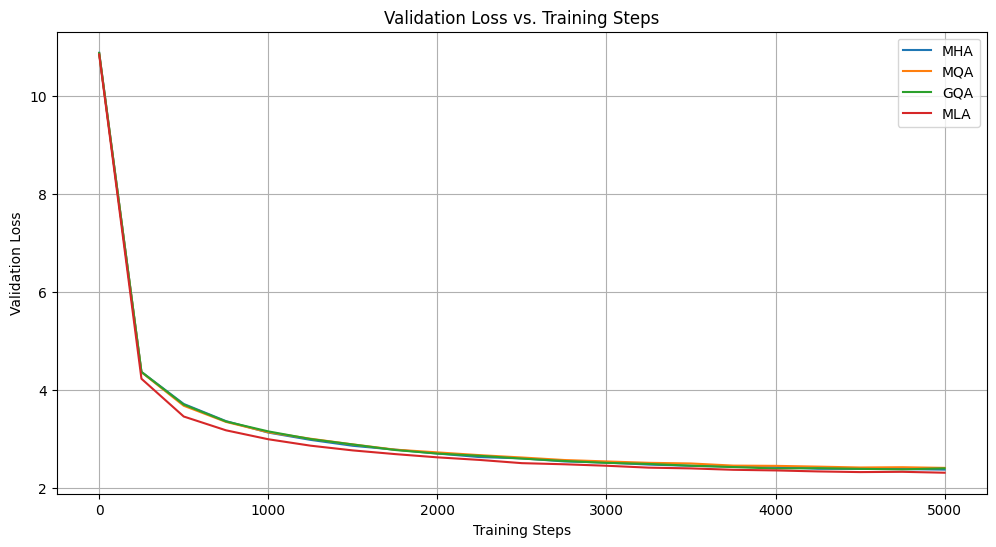

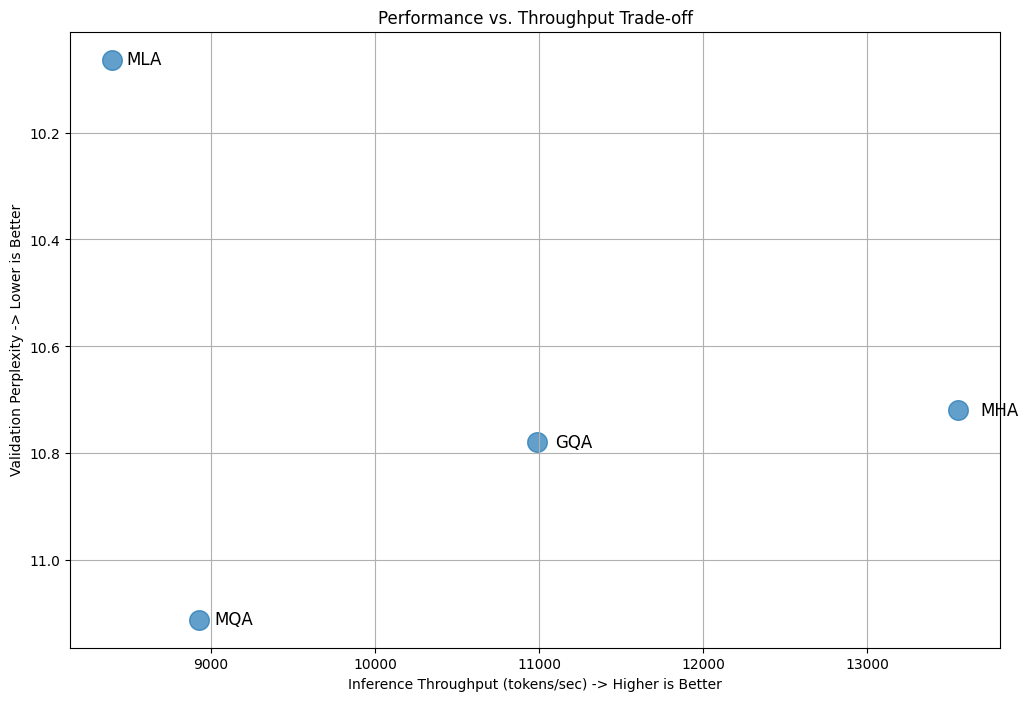

In [110]:
# --- Plot 1: Training Loss Curves ---
plt.figure(figsize=(12, 6))
for model_name, row in df_results.iterrows():
    val_loss_history = row['val_loss_history']
    # Use the eval interval to create a proper x-axis
    steps = [i * EVAL_INTERVAL for i in range(len(val_loss_history))]
    plt.plot(steps, val_loss_history, label=model_name)

plt.title("Validation Loss vs. Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: The Final Trade-off Chart ---
plt.figure(figsize=(12, 8))
# Use perplexity for the y-axis as it's more intuitive (lower is better)
y_axis = df_final_summary['best_val_perplexity']
x_axis = df_final_summary['throughput_tok_per_sec']

plt.scatter(x_axis, y_axis, s=200, alpha=0.7)

# Annotate each point
for model_name, (x, y) in df_final_summary[['throughput_tok_per_sec', 'best_val_perplexity']].iterrows():
    plt.text(x * 1.01, y, model_name, fontsize=12, verticalalignment='center')

plt.title("Performance vs. Throughput Trade-off")
plt.xlabel("Inference Throughput (tokens/sec) -> Higher is Better")
plt.ylabel("Validation Perplexity -> Lower is Better")
plt.grid(True)
# Invert y-axis so the "best" corner is top-right
plt.gca().invert_yaxis()
plt.show()

In [111]:
# --- Detailed Parameter Analysis ---
import pandas as pd

def get_parameter_breakdown(model):
    """ Calculates the parameter count for different parts of the model. """
    params = {
        'Embeddings': 0,
        'Attention Layers': 0,
        'MLP Layers': 0,
        'Final LayerNorm & Head': 0
    }
    for name, p in model.named_parameters():
        if 'wte' in name or 'wpe' in name:
            params['Embeddings'] += p.numel()
        elif 'attn' in name:
            params['Attention Layers'] += p.numel()
        elif 'mlp' in name:
            params['MLP Layers'] += p.numel()
        elif 'ln' in name or 'lm_head' in name:
            params['Final LayerNorm & Head'] += p.numel()
    
    # The lm_head weights are tied with wte, so we subtract them from the final count
    # to avoid double-counting.
    params['Final LayerNorm & Head'] -= model.transformer.wte.weight.numel()
    return params

models_to_analyze = {
    "MHA": MultiHeadAttention,
    "MQA": MultiQueryAttention,
    "GQA": GroupedQueryAttention,
    "MLA": MLAAttention,
}

breakdown_data = {}
print("--- Calculating Detailed Parameter Breakdown ---")

for name, attn_class in models_to_analyze.items():
    model = GPT(BASE_CONFIG, attn_class).to('cpu')
    breakdown_data[name] = get_parameter_breakdown(model)

df_breakdown = pd.DataFrame(breakdown_data).T
df_breakdown['Total Parameters'] = df_breakdown.sum(axis=1)

# Display the formatted table
display(df_breakdown.style.format('{:,.0f}'))

--- Calculating Detailed Parameter Breakdown ---


,Embeddings,Attention Layers,MLP Layers,Final LayerNorm & Head,Total Parameters
MHA,"12,931,328","1,572,864","3,145,728","-12,862,464","4,787,456"
MQA,"12,931,328","884,736","3,145,728","-12,862,464","4,099,328"
GQA,"12,931,328","1,179,648","3,145,728","-12,862,464","4,394,240"
MLA,"12,865,792","1,376,256","3,145,728","-12,862,464","4,525,312"
